## Dependencias

In [72]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_selection import f_regression

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()

## Lectura de datos

In [73]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Regresión_Lineal/day.csv'
df = pd.read_csv(ruta)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [74]:
df.shape

(730, 16)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Definición de variables

In [76]:
um = ['instant']
vart = ['cnt']
varc = [v for v in df.columns if v not in vart and v not in um and df[v].dtype!='object']

## Análisis exploratorio

### Valores nulos

In [77]:
nulos = 1-df.describe().T[['count']]/len(df)
nulos

,count
instant,0.0
season,0.0
yr,0.0
mnth,0.0
holiday,0.0
weekday,0.0
workingday,0.0
weathersit,0.0
temp,0.0
atemp,0.0


### Valores extremos

In [78]:
X = df[varc].copy()

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'yr'}>,
        <AxesSubplot:title={'center':'mnth'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'weekday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weathersit'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'hum'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

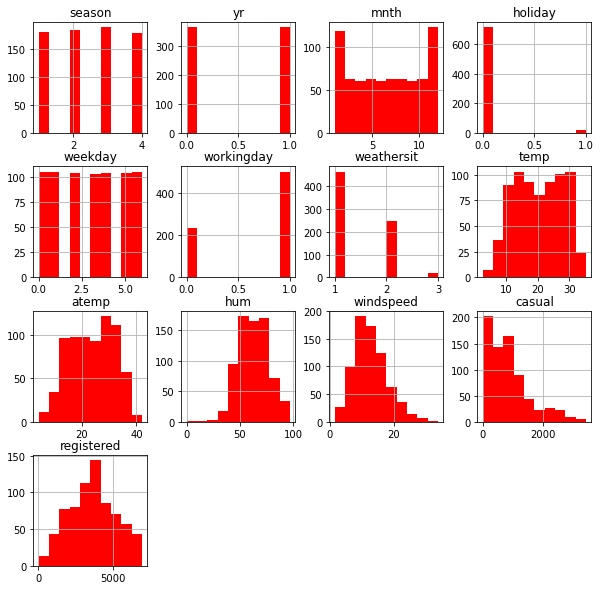

In [79]:
X.hist(figsize=(10,10),color='red')

In [80]:
for v,li,ls in X.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.89726
1    0.10274
Name: ex_, dtype: float64

In [81]:
X[um+vart] = df[um+vart]

In [82]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'yr'}>,
        <AxesSubplot:title={'center':'mnth'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'weekday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weathersit'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'hum'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

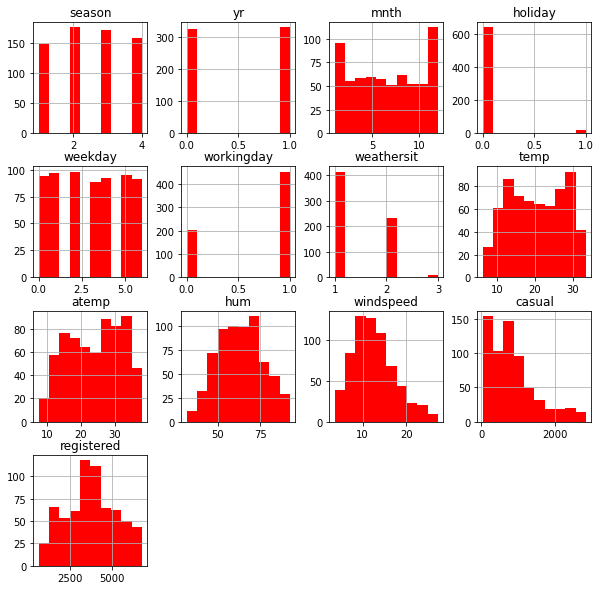

In [83]:
X[varc].hist(figsize=(10,10),color='red')

## Partición

In [84]:
Xt,Xv,yt,yv = train_test_split(X[um+varc],X[um+vart],test_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [85]:
hp=dict(alpha=np.arange(0.1,2,0.1))
modelo = Ridge()
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [86]:
grid.fit(Xt[varc],yt[vart[0]])

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [87]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=0.1)

In [88]:
modelo.fit(Xt[varc],yt[vart[0]])

Ridge(alpha=0.1)

In [89]:
modelo.coef_,modelo.intercept_

(array([ 6.97416545e-07,  2.44161756e-06, -7.61979492e-08, -1.49033059e-06,
         9.41516740e-08, -2.50064296e-06, -1.29082601e-07, -5.80173030e-07,
         7.98733982e-07, -4.61803561e-08, -5.61715476e-08,  9.99999996e-01,
         9.99999999e-01]),
 1.958844222826883e-06)

## Validación del modelo

In [90]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [91]:
St['y^'] = modelo.predict(Xt[varc])
Sv['y^'] = modelo.predict(Xv[varc])

In [92]:
print(mean_absolute_error(y_pred=St['y^'],y_true=St[vart[0]]))
print(mean_absolute_error(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

1.182452468022032e-06
1.2539110458005473e-06


<AxesSubplot:ylabel='Density'>

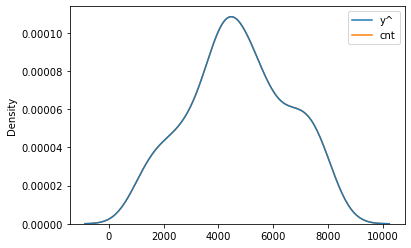

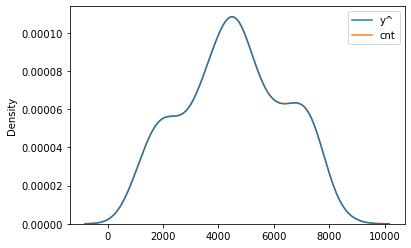

In [93]:
plt.figure()
sns.kdeplot(data=St[['y^']+vart])
plt.figure()
sns.kdeplot(data=Sv[['y^']+vart])